# VGG16

### Loading Libraries

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image

from glob import glob
import random

### Loading the Data

In [12]:
work_dir = 'lung_colon_image_set/'

folders = glob(work_dir + '/*')
print(folders)

images = glob(work_dir + '/*/*/*.jpeg')
print('No. of Images: ', len(images))

['lung_colon_image_set\\colon_image_sets', 'lung_colon_image_set\\lung_image_sets']
No. of Images:  25000


### Plotting Sample Data

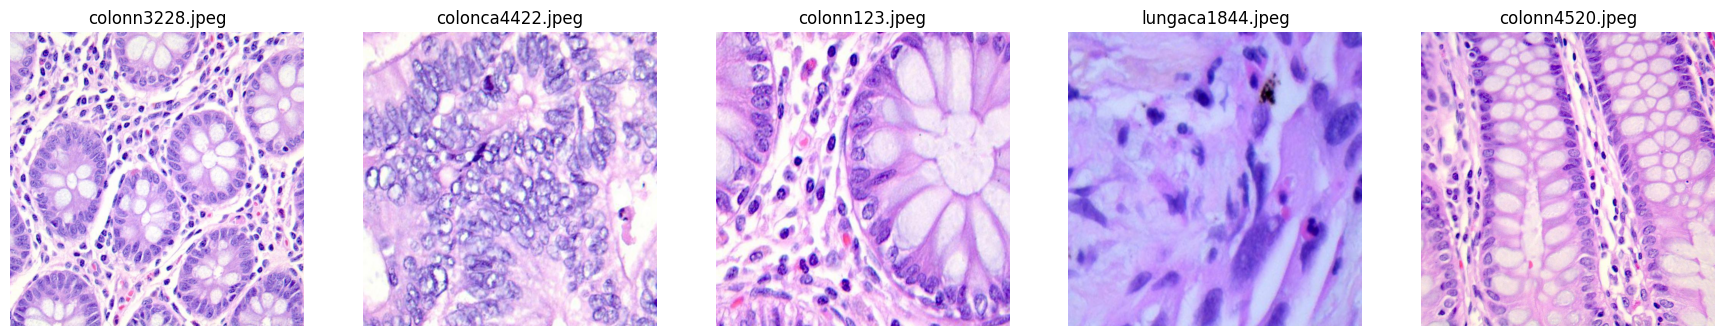

In [42]:
sample_imgs = random.sample(images, 5)

plt.figure(figsize=(22, 8)) 
n = 1

for i in sample_imgs:
    plt.subplot(1, 5, n)
    n += 1
    plt.title(i.split('\\')[3])
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()